In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.signal import detrend
sys.path.append('/home/om2382/scaling_analysis/')
from PopulationCoding.PopulationCoding.dimred import SVCA
sys.path.append('/home/om2382/mft-theory/')
from empirics import random_derangement, shared_variance_components_analsys

In [2]:
data_dir = '/mnt/smb/locker/litwin-kumar-locker/om2382/'
small_file_name = '20210311_left_1p2mm_FOV_50_550um_depth_65percent_60min_no_stim.h5'
T_N_file_name = '20210305_both_6mm_FOV_50_550um_depth_350mW_60min_no_stim_M1.h5'
N_T_file_name = '20210305_both_6mm_FOV_50_550um_depth_350mW_60min_no_stim_M1_transpose.h5'

In [3]:
with h5py.File(os.path.join(data_dir, N_T_file_name), 'r') as f:
    X = f['T_all_transpose'][:,:]
with h5py.File(os.path.join(data_dir, T_N_file_name), 'r') as f:
    Y = f['T_all'][:,:]

In [ ]:
N_subset = 10000

In [3]:
with h5py.File(os.path.join(data_dir, T_N_file_name), 'r') as f:
    print(f.keys())
    #M = f['motion_pcs'][:,:,:]
    #print(f['motion'].shape)
    M = f['motion'][:,:]
    F = f['motion_pcs'][:,:,:10]

<KeysViewHDF5 ['T_all', 'Ym', 'fhz', 'motion', 'motion_pcs', 'nx', 'ny', 'nz', 't', 'velocity_events']>


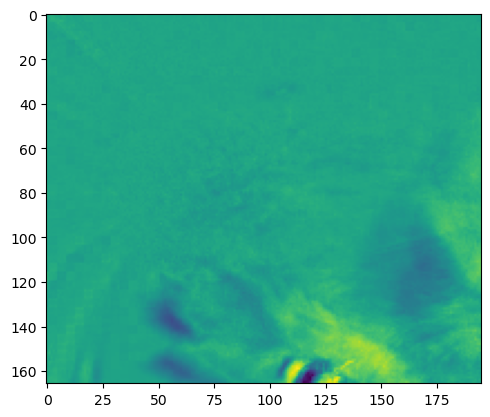

In [36]:
plt.imshow(F[:,:,8])

In [10]:
from sklearn.manifold import TSNE

In [11]:
tsne = TSNE(perplexity=20)
proj = tsne.fit_transform(M)

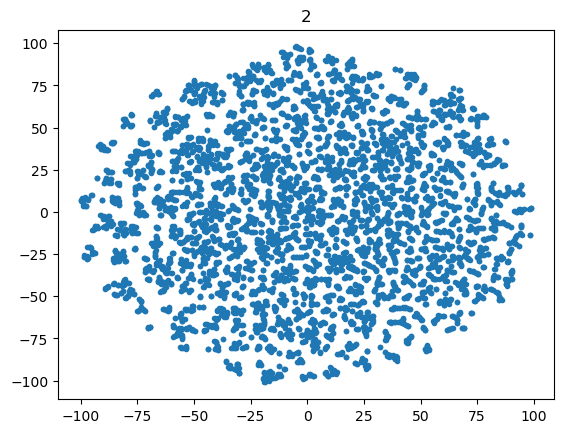

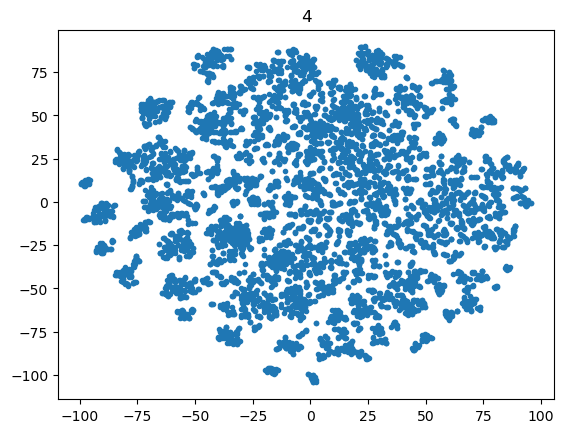

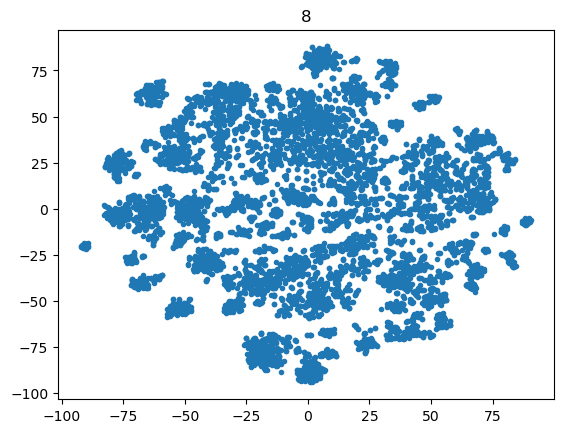

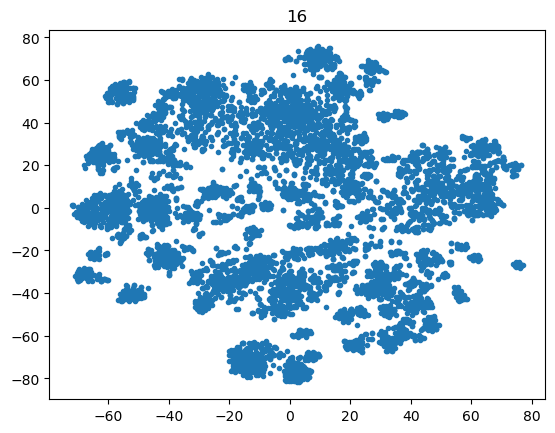

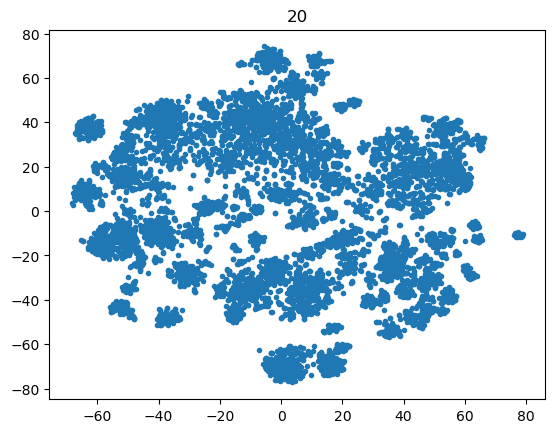

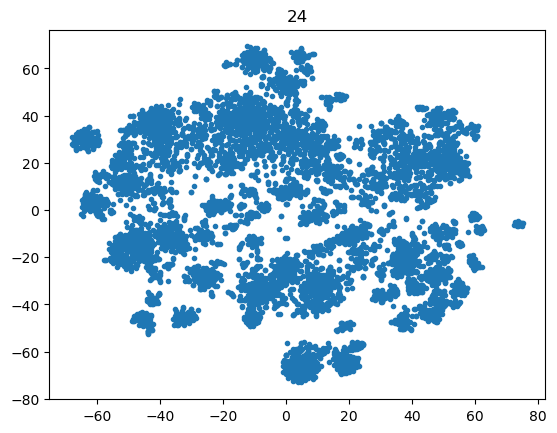

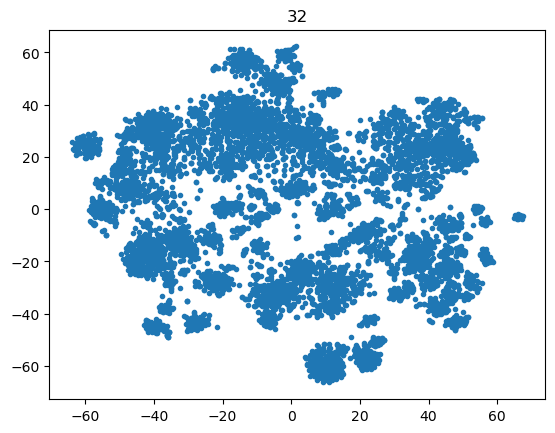

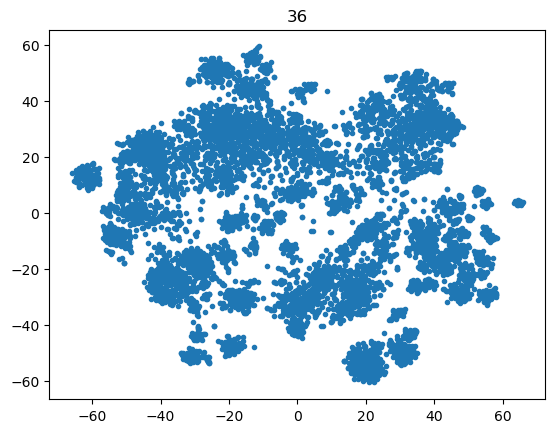

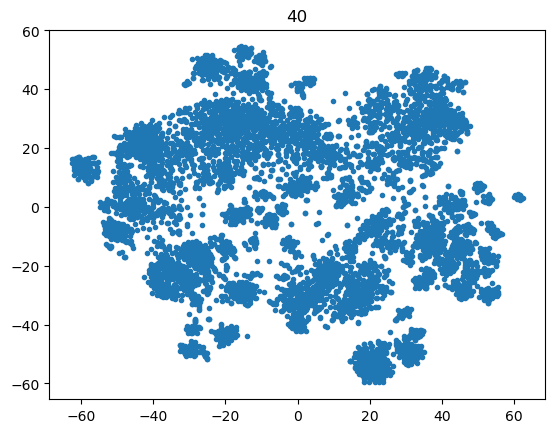

In [19]:
for p in [2, 4, 8, 16, 20, 24, 32, 36, 40]:
    plt.figure()
    tsne = TSNE(perplexity=p)
    proj = tsne.fit_transform(M)
    plt.plot(proj[:,0], proj[:,1], '.')
    plt.title(p)

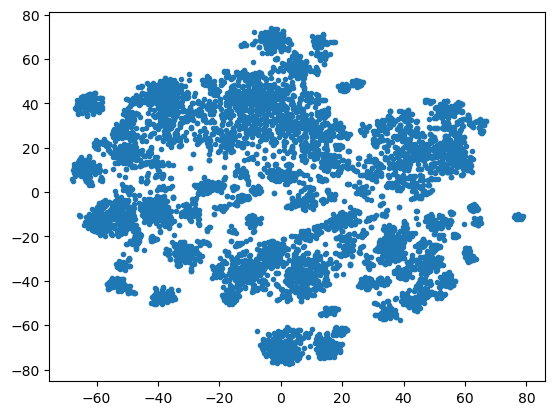

In [12]:
plt.plot(proj[:,0], proj[:,1], '.')


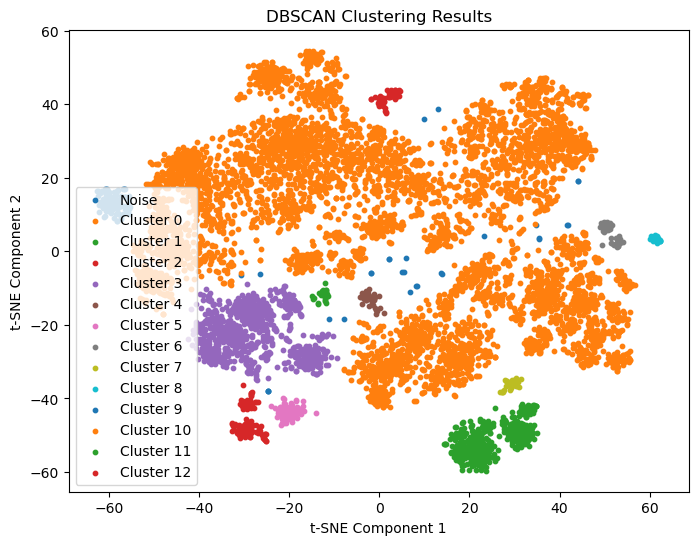

In [26]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np

# Parameters
eps = 3  # Maximum distance for two samples to be considered neighbors
min_samples = 5  # Minimum number of points to form a dense region

# Run DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(proj)

# Visualize
plt.figure(figsize=(8, 6))
unique_labels = np.unique(labels)
for label in unique_labels:
    label_mask = (labels == label)
    plt.scatter(proj[label_mask, 0], proj[label_mask, 1], label=f'Cluster {label}' if label != -1 else 'Noise', s=10)

plt.title('DBSCAN Clustering Results')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


In [29]:
import pickle
with open('files/tsne_data', 'wb') as f:
    pickle.dump(proj, f)

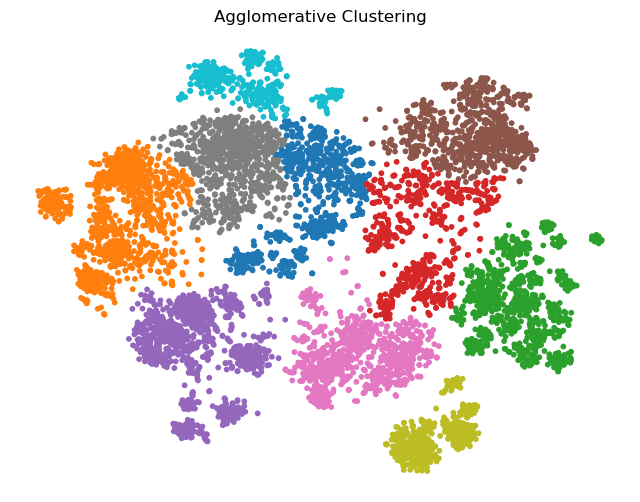

In [30]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# Perform Agglomerative Clustering
clustering = AgglomerativeClustering(n_clusters=10)
labels = clustering.fit_predict(proj)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(proj[:, 0], proj[:, 1], c=labels, s=10, cmap='tab10')
plt.title("Agglomerative Clustering")
plt.axis('off')
plt.show()


In [36]:
[sum(labels == i) for i in set(labels)]

[806, 1092, 996, 654, 1030, 780, 842, 780, 450, 410]

In [58]:
unique_labels = np.unique(labels)
means = np.zeros((len(unique_labels), 3000))
VTs = []
for i_label, label in enumerate(unique_labels):
    label_mask = (labels == label)
    T_in_label = sum(label_mask)
    if False:
        label_mask = np.random.choice(range(Y_subset.shape[0]), replace=False, size=sum(label_mask))
        
    data = Y_subset[label_mask]
    data = data - data.mean(0)[None,:]
    U, S1, VT1 = np.linalg.svd(data[:len(data)//2])
    U, S2, VT2 = np.linalg.svd(data[len(data)//2:])
    #plt.figure()
    #plt.plot(S, '.')
    VTs.append(VT1[:3,:])
    VTs.append(VT2[:3,:])
    #cov = np.einsum('ti, tj -> ij', data, data)/(data.shape[0] - 1)
    ##PR = np.trace(cov)**2 / (cov**2).sum() #/ T_in_label
    #print(PR)
    #means[i_label,:] = Y_subset[label_mask].mean(0)
#means = means - means.mean(0)[None,:]
#mean_cov = np.einsum('ti, tj -> ij', means, means)/(means.shape[0] - 1)
#mean_PR = np.trace(mean_cov)**2 / (mean_cov**2).sum() #/ means.shape[0]
#print('across PR: {}'.format(mean_PR))

In [59]:
V_ = np.vstack(VTs)

In [55]:
V_.shape

(40, 3000)

In [60]:
alignment = np.einsum('ci, di -> cd', V_, V_) / 3000

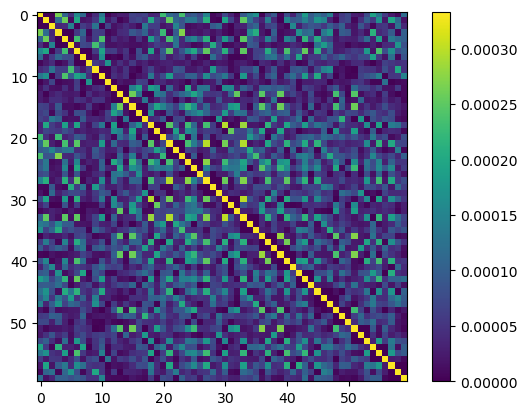

In [61]:
plt.imshow(np.abs(alignment))
plt.colorbar()

In [18]:
means = np.zeros((len(unique_labels[1:]), 3000))
for i_label, label in enumerate(unique_labels[1:]):
    label_mask = (labels == label)
    T_in_label = sum(label_mask)
    if False:
        label_mask = np.random.choice(range(Y_subset.shape[0]), replace=False, size=sum(label_mask))
        
    data = Y_subset[label_mask]
    data = data - data.mean(0)[None,:]
    cov = np.einsum('ti, tj -> ij', data, data)/(data.shape[0] - 1)
    PR = np.trace(cov)**2 / (cov**2).sum() #/ T_in_label
    print(PR)
    means[i_label,:] = Y_subset[label_mask].mean(0)
means = means - means.mean(0)[None,:]
mean_cov = np.einsum('ti, tj -> ij', means, means)/(means.shape[0] - 1)
mean_PR = np.trace(mean_cov)**2 / (mean_cov**2).sum() #/ means.shape[0]
print('across PR: {}'.format(mean_PR))

52.89287826187555
126.16549335663397
68.20172904838019
62.695770604711875
23.644944750460652
130.60615472276902
8.231275448581549
37.45191171082255
17.29991083217235
11.090641424384183
71.02184760051219
12.36097606101278
39.652472053048896
187.1218815385346
62.92412242544178
266.22324901929437
28.543956420139722
137.3423353700392
64.25770769258557
37.281059106960754
6.91831022538697
74.60112383286051
58.965499329699334
21.04198471967187
23.056112969853736
24.8800880168421
30.90557442149444
167.81822548560487
341.79155560213013
121.95526660541222
295.99612770572054
4.849001669103595
24.747810215512636
10.356590618706285
14.225433062702358
11.435594880615533
8.696730654589947
99.23117105337535
4.832416098849658
11.30311763618127
4.924154374291976
351.6118033593071
20.95694700825207
47.82621662796157
46.90344202275063
6.751590055571053
12.569954611222622
7.8782893327747825
94.12833415152778
1.0000000862827494
6.853945128772975
3.871022934092384
118.27642398333452
8.635335405459216
15.5434

In [61]:
mean_PR

7.917294714714631

In [7]:
subset_size = 3000
idx_subset = np.random.choice(list(range(X.shape[0])), subset_size, replace=False)
X_subset = X[idx_subset,:]
X_subset = X_subset - X_subset.mean(1)[:,None]

In [8]:
Y_subset = X_subset.T

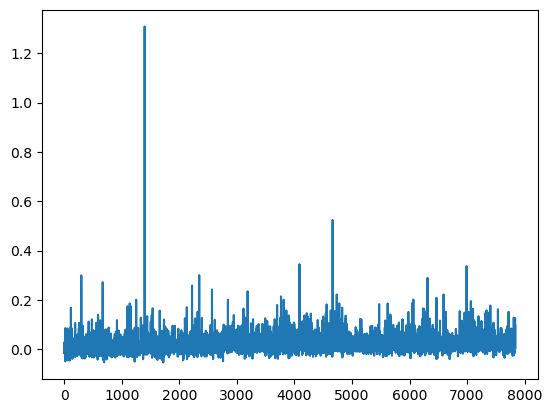

In [7]:
plt.plot(X[0])

In [8]:
PR_T = [0]
A = [0]
B = [0]
C = [0]
num = [0]
denom = [0]
corr = 0
var = 0
num_ = 0
denom_ = 0
N = Y_subset.shape[1]
for t in range(0, Y_subset.shape[0]):
    if t % 1000 == 0:
        print(t)
    A_ = np.sum(Y_subset[t]**2)**2
    B_ = 2 * np.sum(var) * np.sum(Y_subset[t]**2)
    C_ = 2 * np.sum(corr * Y_subset[t][:,None]*Y_subset[t][None,:])
    num_ += B_ + A_
    denom_ += C_ + A_
    PR_T.append(num_/denom_)
    var += np.sum(Y_subset[t]**2)
    corr += Y_subset[t][:,None]*Y_subset[t][None,:]
    A.append(A_)
    B.append(B_)
    C.append(C_)
    num.append(num_)
    denom.append(denom_)
PR_T = np.array(PR_T)
A = np.array(A)
B = np.array(B)
C = np.array(C)
num = np.array(num)
denom = np.array(denom)

0


KeyboardInterrupt: 

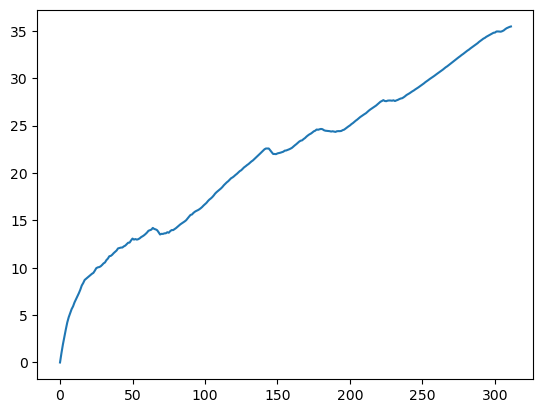

In [9]:
plt.plot(PR_T)

(4000.0, 4100.0)

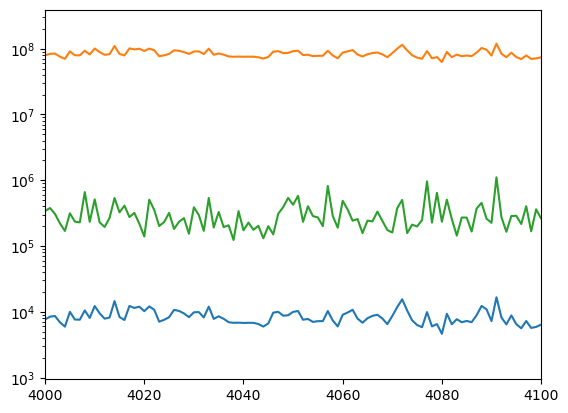

In [16]:
plt.plot(A)
plt.plot(B)
plt.plot(C)
plt.yscale('log')
plt.xlim([4000, 4100])

In [9]:
from scipy.spatial import distance_matrix
dist_matrix = distance_matrix(Y_subset, Y_subset)

In [10]:
i, j = np.triu_indices(dist_matrix.shape[0])

In [11]:
D = dist_matrix[i, j]

In [13]:
Y_subset.shape

(7840, 3000)

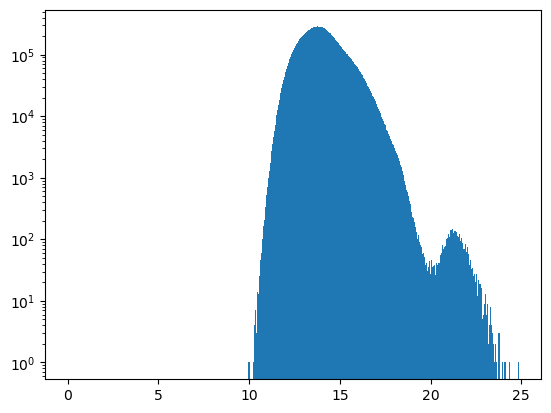

In [12]:
plt.hist(D, bins=1000)
plt.yscale('log')

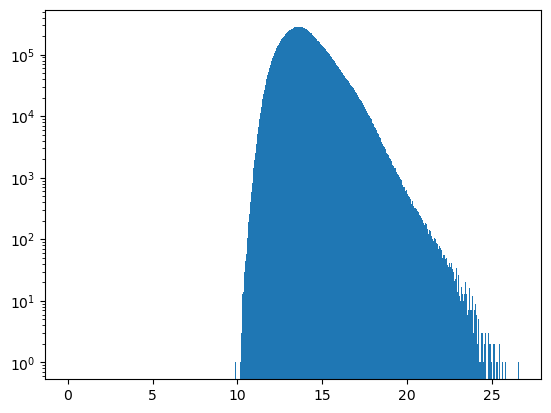

In [14]:
plt.hist(D, bins=1000)
plt.yscale('log')

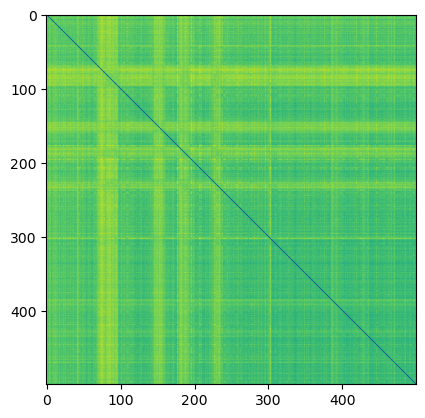

In [17]:
plt.imshow(dist_matrix[:500,:500])

In [19]:
import numpy as np
from scipy.spatial import distance_matrix

def calculate_dpr(data, r):
    """
    Calculates the scale-dependent participation ratio (D_PR) for a dataset.
    
    Parameters:
    data (numpy.ndarray): A 2D array where each row is a data point.
    r (float): The radius of the ball around each point.

    Returns:
    float: The averaged participation ratio D_PR(r).
    """
    T, N = data.shape  # T is the number of data points, N is the dimensionality

    dpr_sum = 0  # Accumulates the sum for D_PR

    # Calculate distance matrix for all points
    dist_matrix = distance_matrix(data, data)

    for i in range(T):
        # Find all points within a ball of radius r around point i
        neighbors = np.where(dist_matrix[i] < r)[0]

        if len(neighbors) < 2:
            continue  # Skip if fewer than 2 points in the ball

        # Compute the local covariance matrix Si(r)
        local_points = data[neighbors] - np.mean(data[neighbors], axis=0)
        S_i_r = np.cov(local_points, rowvar=False)

        # Compute the participation ratio
        trace_Si = np.trace(S_i_r)
        trace_Si2 = np.trace(np.dot(S_i_r, S_i_r))

        if trace_Si2 == 0:
            continue  # Avoid division by zero

        dpr_i = (trace_Si ** 2) / trace_Si2
        dpr_sum += dpr_i

    # Average over all data points
    dpr_avg = dpr_sum / T
    return dpr_avg


# Example usage:
# Generate some random data
np.random.seed(0)
data = Y_subset  # 100 points in 3 dimensions
r = 1.0  # Radius for the ball

dpr_value = calculate_dpr(data, r)
print(f"D_PR({r}) = {dpr_value}")


KeyboardInterrupt: 

In [20]:
r = 1.0
data = Y_subset

T, N = data.shape  # T is the number of data points, N is the dimensionality

dpr_sum = 0  # Accumulates the sum for D_PR

# Calculate distance matrix for all points
dist_matrix = distance_matrix(data, data)

for i in range(T):
    if i%10 == 0:
        print(i)
    # Find all points within a ball of radius r around point i
    neighbors = np.where(dist_matrix[i] < r)[0]

    if len(neighbors) < 2:
        continue  # Skip if fewer than 2 points in the ball

    # Compute the local covariance matrix Si(r)
    local_points = data[neighbors] - np.mean(data[neighbors], axis=0)
    S_i_r = np.cov(local_points, rowvar=False)

    # Compute the participation ratio
    trace_Si = np.trace(S_i_r)
    trace_Si2 = np.trace(np.dot(S_i_r, S_i_r))

    if trace_Si2 == 0:
        continue  # Avoid division by zero

    dpr_i = (trace_Si ** 2) / trace_Si2
    dpr_sum += dpr_i

# Average over all data points
dpr_avg = dpr_sum / T

KeyboardInterrupt: 

In [21]:
data.shape

(7840, 3000)

In [19]:
subset_size = 3000
idx_subset = np.random.choice(list(range(X.shape[0])), subset_size, replace=False)
X_subset = X[idx_subset]
Y_subset = Y[:,idx_subset]
X_subset = X_subset - X_subset.mean(1)[:,None]
Y_subset = Y_subset - Y_subset.mean(0)[None, :]
X_norm = X_subset / np.sqrt(np.square(X_subset).sum(0))[None,:]
Y_norm = Y_subset / np.sqrt(np.square(Y_subset).sum(1))[:,None]
#C_tt = np.einsum('it, si -> ts', X_subset, Y_subset)
C_tt = np.einsum('it, si -> ts', X_norm, Y_norm)

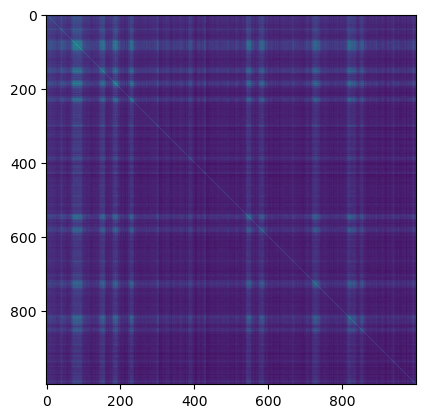

In [11]:
plt.imshow(C_tt[:1000, :1000])

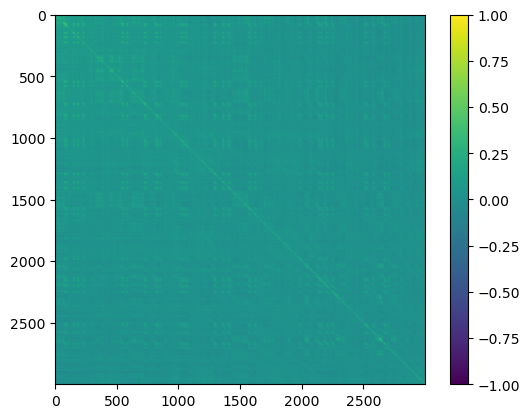

In [23]:
plt.imshow(C_tt[:3000, :3000], vmin=-1, vmax=1)
plt.colorbar()

In [4]:
subset_size = 1000
idx_subset = np.random.choice(list(range(X.shape[0])), subset_size, replace=False)
X_subset = X[idx_subset]
cov_neur, var_neur, u, v, _ = SVCA(X_subset)

In [6]:
sk, sk_tot, prv = shared_variance_components_analsys(X_subset)

done with svd)
done with Sk
done with Sk_tot_1


(0.0, 100.0)

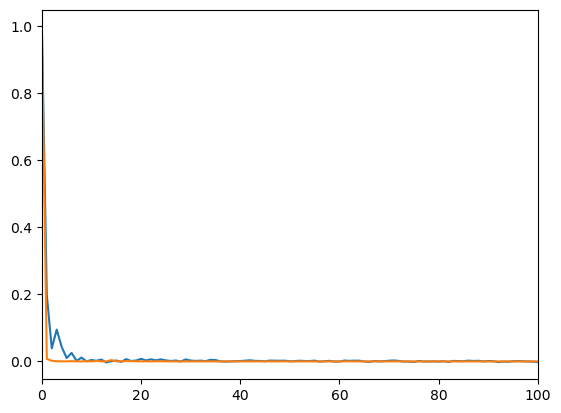

In [14]:
plt.plot(cov_neur/cov_neur[0])
plt.plot(sk/sk[0])
plt.xlim([0, 100])

In [9]:
from scipy.optimize import curve_fit
# Define the power law function
def power_law(x, a, b):
    return a * np.power(x, b)

# Define a linear function for fitting in log-log space
def linear_fit(x, m, c):
    return m * x + c

In [14]:
subset_size = 4000
idx_subset = np.random.choice(list(range(X.shape[0])), subset_size, replace=False)
X_subset = X[idx_subset]
r = X_subset - X_subset.mean(1)[:,None]

In [ ]:
cov = np.einsum('it, jt -> ij', r, r) / (r.shape[1] - 1)

In [15]:
#eigs, vecs = np.linalg.eig(cov)
U, S, VT = np.linalg.svd(r)

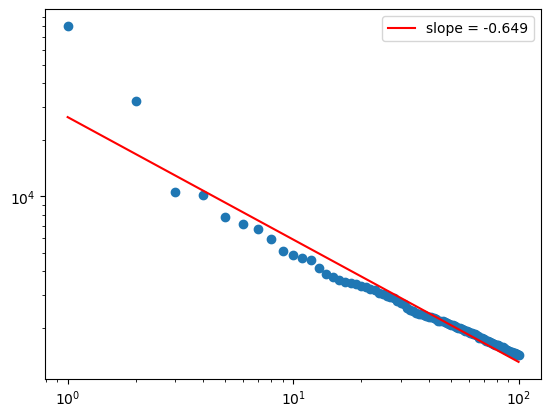

In [18]:
n_modes = 100
#eigs = np.array(sorted(np.abs(eigs))[::-1])
x_data = np.arange(1, n_modes + 1)
#y_data = eigs[:n_modes]
y_data = S[:n_modes]**2
#y_data = np.abs(cov_neur[:n_modes]/cov_neur[0])

# Log-log transformation
log_x_data = np.log(x_data)
log_y_data = np.log(y_data)

# Fit the data in log-log space
params, covariance = curve_fit(linear_fit, log_x_data, log_y_data)
slope, intercept = params

# Extract the power law parameters
a = np.exp(intercept)
b = slope

#ax[i,j].set_title(f"eig-x slope = {b:.3f}")
plt.scatter(x_data, y_data, label='_nolegend_')
plt.plot(x_data, power_law(x_data, a, b), color='red', label=f'slope = {b:.3f}')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [ ]:
powers = []
N_iters = 1000
for i in range(N_iters):
    subset_size = 500
    idx_subset = np.random.choice(list(range(X.shape[0])), subset_size, replace=False)
    X_subset = X[idx_subset]
    r = X_subset - X_subset.mean(1)[:,None]
    U, S, VT = np.linalg.svd(r)
    n_modes = 100
    x_data = np.arange(1, n_modes + 1)
    y_data = S[:n_modes]**2

    # Log-log transformation
    log_x_data = np.log(x_data)
    log_y_data = np.log(y_data)

    # Fit the data in log-log space
    params, covariance = curve_fit(linear_fit, log_x_data, log_y_data)
    slope, intercept = params
    powers.append(slope)
plt.plot(powers)

In [ ]:
plt.hist(powers)

In [ ]:
X_mean = X.mean(1)
X_demeaned = X - X_mean.reshape(-1, 1)
    #X_zscores = X_demeaned / np.std(X_demeaned, 1).reshape(-1, 1)

In [ ]:
lags = list(range(500))
N_subset = 10000
X_subset = X_demeaned[:N_subset]
X_zscores = X_subset / np.std(X_subset, 1).reshape(-1, 1)
#X_subset = detrend(X_subset, axis=1)
idx = random_derangement(N_subset)
X_shuffled = X_subset[idx,:]
#X_shuffled = X_subset
acovs = np.zeros((N_subset, len(lags)))
ccovs = np.zeros((N_subset, len(lags)))
for lag in lags:
    if lag % 100 == 0:
        print(lag)
    acovs[:,lag] = np.sum(X_subset * np.roll(X_subset, lag, axis=1), axis=1)/(X_subset.shape[1] - 1)
    ccovs[:,lag] = np.sum(X_shuffled * np.roll(X_subset, lag, axis=1), axis=1)/(X_subset.shape[1] - 1)

In [ ]:
dt = 0.4587799
y1 = np.square(acovs).mean(0)
y2 = np.square(ccovs).mean(0)
plt.plot(np.arange(len(lags))*dt, y1/y1[10] * 2)
plt.plot(np.arange(len(lags))*dt, y2/y2[0])
#plt.xlim([0, 20])
#plt.ylim([0, np.amax(y1)*1.05])
#plt.ylim([0,])
plt.ylim([0, 3])

In [ ]:
#plt.plot(ccovs.T)
dt = 0.4587799
y = np.square(ccovs).mean(0)
plt.plot(np.arange(len(lags))*dt, y)
#plt.xlim([0, 20])
plt.ylim([0, np.amax(y)*1.05])

In [ ]:
#plt.plot(ccovs.T)
dt = 0.4587799
y = np.square(ccovs).mean(0)
plt.plot(np.arange(len(lags))*dt, y)
plt.xlim([0, 10])
plt.ylim([0, np.amax(y)*1.05])
plt.ylim([0, np.amax(y)*0.01])

In [ ]:
X_zscores = X_demeaned / np.std(X_demeaned, 1).reshape(-1, 1)

In [ ]:
with h5py.File(os.path.join(data_dir, T_N_file_name), 'r') as f:
    #X_T_N = f['T_all'][:,:]
    times = f['t'][:]
    nx = f['nx'][:]

In [12]:
N = X_subset.shape[0]
T = X_subset.shape[1]
X_demeaned = X_subset - X_subset.mean(1)[:,None]

In [9]:
ntrain = sorted(np.random.choice(range(0, N), N//2, replace=False))
ntest = sorted(list(set(range(0,N)) - set(ntrain)))

In [10]:
T_checkerboard = 144 #samples, not seconds
T_indices = np.array(range(0, T // T_checkerboard * T_checkerboard))
T_indices = T_indices.reshape((-1, T_checkerboard))
itrain = T_indices[0::2].flatten()
itest = T_indices[1::2].flatten()

In [13]:
sneur, vneur, u, v, pca = SVCA(X_demeaned, ntrain, ntest, itrain, itest, n_randomized=10)

In [ ]:
prv = shared_variance_components_analsys(X_demeaned)

done with svd)


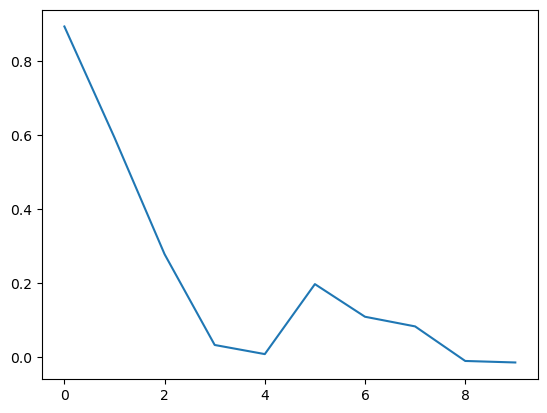

In [15]:
plt.plot(sneur/vneur)
plt.plot(prv)

In [ ]:
idx = random_derangement(N)
ccov = (X_demeaned[idx,:] * X_demeaned).sum(1) / (T - 1)
acov = (X_demeaned**2).sum(1) / (T - 1)

In [ ]:
plt.hist(np.log10(ccov**2), bins=100)
plt.hist(np.log10(acov**2), bins=100)

In [ ]:
np.amax(ccov)

In [ ]:
X_demeaned.shape

In [ ]:
T = X_T_N.shape[0]
cov_TT = np.zeros((T, T))
for t1 in range(T):
    if t1 % 100 == 0 or t1 < 10:
        print(t1)
    for t2 in range(T):
        cov_TT[t1,t2] = np.mean((X_T_N[t1] - X_mean) * (X_T_N[t2] - X_mean))

In [ ]:
#confirm evenly spaced temporal samples
print(set(times[1:] - times[:-1]))
dt = times[1] - times[0]


In [ ]:
#sample some autocovariance functions
N_sample = 200
i_sample = sorted(np.random.choice(range(0, X.shape[0]), N_sample, replace=False))
X_subset = X_zscores[i_sample,:]
X_subset = detrend(X_subset, -1)
fpower = np.abs(np.fft.rfft(X_subset, axis=1, norm='ortho'))**2
acov = np.fft.irfft(fpower, axis=1)
time = np.arange(0, 50, dt)
_ = plt.plot(time, acov[:,:len(time)].T, color='C0', alpha=0.1)
#plt.xlim([0, 2])

In [ ]:
#plot your favorite trajectory
time = np.arange(0, X.shape[1]*dt, dt)
long_autocov_example = X_demeaned[i_sample[np.argmax(acov[:,1000])],:]
plt.plot(time, long_autocov_example)

In [ ]:
ret = detrend(long_autocov_example)

In [ ]:
plt.plot(ret)

In [ ]:
ret.shape

In [16]:
def shared_variance_components_analsys(X):
    """Do SVCA on an array X where we can split into test and train data points arbitrary (WLOG first and second halfs
    for each.)"""

    T, N = X.shape
    F_train, G_train = X[:T//2,:N//2], X[:T//2,N//2:]
    F_test, G_test = X[T//2:,:N//2], X[T//2:,N//2:]

    C = F_train.T.dot(G_train) / (T//2 - 1)
    U, S, VT = np.linalg.svd(C)
    print('done with svd)')
    Sk = np.einsum('ik, it, tj, kj -> k', U, F_test.T, G_test, VT)
    print('done with first Sk')
    Sk_tot_1 = np.einsum('ik, it, tj, jk -> k', U, F_test.T, F_test, U)
    print('done with Sk_tot_1')
    Sk_tot_2 = np.einsum('ki, it, tj, kj -> k', VT, G_test.T, G_test, VT)
    Sk_tot = Sk_tot_1 + Sk_tot_2
    percent_reliable_var = (Sk/(T//2)) / (Sk_tot/T)

    return percent_reliable_var

In [ ]:
fpower_ = np.abs(np.fft.rfft(ret, norm='ortho'))**2
acov_ = np.fft.irfft(fpower_)
time = np.arange(0, 5, dt)
plt.plot(time, acov_[:len(time)])

In [ ]:
with h5py.File(os.path.join(data_dir, small_file_name), 'r') as f:
    #X = f['T_all'][:,:]
    times = f['t'][:]
    print(set(times[1:] - times[:-1]))
    dt = times[1] - times[0]

In [ ]:
#sample some autocovariance functions
X_mean = X.mean(0)
X_demeaned = X - X_mean
N_sample = 200
i_sample = sorted(np.random.choice(range(0, X.shape[0]), N_sample, replace=False))
X_subset = X_demeaned[i_sample,:]
fpower = np.abs(np.fft.rfft(X_subset, axis=1, norm='ortho'))**2
acov = np.fft.irfft(fpower, axis=1)
time = np.arange(0, 100, dt)
_ = plt.plot(time, acov[:,:len(time)].T, color='C0', alpha=0.1)

In [ ]:
with h5py.File(os.path.join(data_dir, small_file_name), 'r') as f:
    Y = f['T_all'][:,:]
    Y_mean = Y.mean(0)
    Y_demeaned = Y - Y_mean.reshape(1, -1)

In [ ]:
idx = random_derangement(Y.shape[1])
Ty = Y.shape[0]
ccov_y = (Y_demeaned[:,idx] * Y_demeaned).sum(0) / (Ty - 1)
acov_y = (Y_demeaned**2).sum(0) / (Ty - 1)

In [ ]:
PR_x = np.mean(acov)**2/(np.mean(acov**2) + N * np.mean(ccov**2))

In [ ]:
PR_y = np.mean(acov_y)**2/(np.mean(acov_y**2) + Y.shape[1] * np.mean(ccov_y**2))

In [ ]:
PR_y * Y.shape[1]

In [ ]:
plt.hist(np.log10(ccov_y**2), bins=100, alpha=0.5)
plt.hist(np.log10(acov_y**2), bins=100, alpha=0.5)

In [ ]:
plt.hist(np.log10(ccov**2), bins=100, alpha=0.5)
plt.hist(np.log10(acov**2), bins=100, alpha=0.5)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
bins = np.linspace(-15, 1, 100)
hist_acov, _ = np.histogram(np.log10(acov**2), bins=bins, density=True)
hist_ccov, _ = np.histogram(np.log10(ccov**2), bins=bins, density=True)
hist_acov_y, _ = np.histogram(np.log10(acov_y**2), bins=bins, density=True)
hist_ccov_y, _ = np.histogram(np.log10(ccov_y**2), bins=bins, density=True)
ax[0].plot(bins[:-1], hist_acov)
ax[0].plot(bins[:-1], hist_ccov)
ax[1].plot(bins[:-1], hist_acov_y)
ax[1].plot(bins[:-1], hist_ccov_y)

In [ ]:
#big dataset
idx = random_derangement(N)
X_detrended = detrend(X_demeaned, axis=1)
ccov = (X_detrended[idx,:] * X_detrended).sum(1) / (T - 1)
acov = (X_detrended**2).sum(1) / (T - 1)

#small dataset
idx = random_derangement(Y.shape[1])
Ty = Y.shape[0]
Y_detrended = detrend(Y_demeaned, axis=0)
ccov_y = (Y_detrended[:,idx] * Y_detrended).sum(0) / (Ty - 1)
acov_y = (Y_detrended**2).sum(0) / (Ty - 1)

fig, ax = plt.subplots(2, 1, figsize=(10, 5))
bins = np.linspace(-15, 1, 100)
hist_acov, _ = np.histogram(np.log10(acov**2), bins=bins, density=True)
hist_ccov, _ = np.histogram(np.log10(ccov**2), bins=bins, density=True)
hist_acov_y, _ = np.histogram(np.log10(acov_y**2), bins=bins, density=True)
hist_ccov_y, _ = np.histogram(np.log10(ccov_y**2), bins=bins, density=True)
ax[0].plot(bins[:-1], hist_acov)
ax[0].plot(bins[:-1], hist_ccov)
ax[1].plot(bins[:-1], hist_acov_y)
ax[1].plot(bins[:-1], hist_ccov_y)

In [ ]:
with h5py.File(os.path.join(data_dir, N_T_file_name), 'r') as f:
    X = f['T_all_transpose'][:,:]
    X_mean = X.mean(1)
    X_demeaned = X - X_mean.reshape(-1, 1)
    X_zscores = X_demeaned / np.std(X_demeaned, 1).reshape(-1, 1)

In [ ]:
with h5py.File(os.path.join(data_dir, small_file_name), 'r') as f:
    Y = f['T_all'][:,:].T
    Y_mean = Y.mean(1)
    Y_demeaned = Y - Y_mean.reshape(-1, 1)
    Y_zscores = Y_demeaned / np.std(Y_demeaned, 1).reshape(-1, 1)

In [ ]:
#big dataset
Nx, Tx = X.shape
Ny, Ty = Y.shape

idx = random_derangement(Nx)
#X_detrended = detrend(X_zscores, axis=1)
ccov = (X_zscores[idx,:] * X_zscores).sum(1) / (Tx - 1)
acov = (X_zscores**2).sum(1) / (Tx - 1)

#small dataset
idx = random_derangement(Ny)
#Y_detrended = detrend(Y_demeaned, axis=0)
ccov_y = (Y_zscores[idx, ] * Y_zscores).sum(1) / (Ty - 1)
acov_y = (Y_zscores**2).sum(1) / (Ty - 1)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
bins = np.linspace(-7, 1, 100)
hist_acov, _ = np.histogram(np.log10(acov**2), bins=bins, density=True)
hist_ccov, _ = np.histogram(np.log10(ccov**2), bins=bins, density=True)
hist_acov_y, _ = np.histogram(np.log10(acov_y**2), bins=bins, density=True)
hist_ccov_y, _ = np.histogram(np.log10(ccov_y**2), bins=bins, density=True)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
#ax[0].plot(bins[1:], hist_acov)
ax[0].plot(bins[1:], hist_ccov)
#ax[1].plot(bins[1:], hist_acov_y)
ax[1].plot(bins[1:], hist_ccov_y)

In [ ]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return list(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def linearly_interpolate_colors(col1, col2, N):

    if '#' in col1:
        c1 = hex_to_rgb(col1)
    if '#' in col2:
        c2 = hex_to_rgb(col2)

    cols = np.linspace(c1, c2, N).astype(int)
    return [rgb_to_hex(tuple(c)) for c in cols]

cols = linearly_interpolate_colors('#366B9F', '#D32729', len(range(0, 7000, 1000)))

In [ ]:
#fig, ax = plt.subplots(2, 1, figsize=(10, 5))
fig = plt.figure(figsize=(10, 10))

T_sample = 1000
for i_t_start, T_start in enumerate(range(0, 7000, T_sample)):
    idx = random_derangement(Nx)
    #X_detrended = detrend(X_zscores, axis=1)
    ccov = (X_zscores[idx,T_start:T_start+T_sample]*
            X_zscores[:,T_start:T_start+T_sample]).sum(1) / (T_sample - 1)

    bins = np.linspace(-7, 1, 100)
    hist_ccov, _ = np.histogram(np.log10(ccov**2), bins=bins, density=True)
    
    plt.plot(bins[1:], hist_ccov, color=cols[i_t_start])

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

T_sample = 500
cols = linearly_interpolate_colors('#366B9F', '#D32729', len(range(0, 7000, T_sample)))
for i_t_start, T_start in enumerate(range(0, 7000, T_sample)):
    idx = random_derangement(Nx)
    #X_detrended = detrend(X_zscores, axis=1)
    ccov = (X_zscores[idx,T_start:T_start+T_sample]*
            X_zscores[:,T_start:T_start+T_sample]).sum(1) / (T_sample - 1)

    bins = np.linspace(-7, 1, 100)
    hist_ccov, _ = np.histogram(np.log10(ccov**2), bins=bins, density=True)
    
    ax[0].plot(bins[1:], hist_ccov, color=cols[i_t_start])
    
T_sample = 1000
cols = linearly_interpolate_colors('#366B9F', '#D32729', len(range(0, 7000, T_sample)))
for i_t_start, T_start in enumerate(range(0, 7000, T_sample)):
    idx = random_derangement(Nx)
    #X_detrended = detrend(X_zscores, axis=1)
    ccov = (X_zscores[idx,T_start:T_start+T_sample]*
            X_zscores[:,T_start:T_start+T_sample]).sum(1) / (T_sample - 1)

    bins = np.linspace(-7, 1, 100)
    hist_ccov, _ = np.histogram(np.log10(ccov**2), bins=bins, density=True)
    
    ax[1].plot(bins[1:], hist_ccov, color=cols[i_t_start])

In [ ]:
with h5py.File(os.path.join(data_dir, T_N_file_name), 'r') as f:
    X_T_N = f['T_all'][:,:]
    times = f['t'][:]
    nx = f['nx'][:]

In [ ]:
T_sample = 1000
cols = linearly_interpolate_colors('#366B9F', '#D32729', len(range(0, 7000, T_sample)))
randomized_T = np.array(range(7000))
np.random.shuffle(randomized_T)
for i_t_start, T_start in enumerate(range(0, 7000, T_sample)):
    print(i_t_start)
    idx = random_derangement(Nx)
    #X_detrended = detrend(X_zscores, axis=1)
    T_idx = randomized_T[T_start:T_start+T_sample]
    ccov = (X_zscores[idx,:][:,T_idx]*X_zscores[:,T_idx]).sum(1) / (T_sample - 1)

    bins = np.linspace(-7, 1, 100)
    hist_ccov, _ = np.histogram(np.log10(ccov**2), bins=bins, density=True)
    
    ax[2].plot(bins[1:], hist_ccov, color=cols[i_t_start])
    

In [ ]:
fig.show()